In [4]:
import struct
import matplotlib.pyplot as plt
import numpy as np
import math


f=open('10_31_2024c02.D24','rb')
file=f.read()



In [5]:

def search (data,format:str,start:int,end:int,size:int):
    '''Extrae la información de un archivo en binario, se debe indicar el tipo de 
    datos "format" y el tamaño, en bytes, del tipo de dato "size". '''
    list=[]
    position=-1
    for byte in data[start:end+1]:
        position+=1 
        if position%size==0:
           i=position+start
           val=(struct.unpack(format,data[i:i+size]))[0]
           list.append(val)
        else:
           continue     
    return list


In [6]:
def header (data):
    '''Extrae la información del header de los archivos de collect y la almacena en un diccionario.
    Requiere la función search()'''
    note_list=search(file,'c',28,106,1)    
    note=''    
    for letter in note_list:
        if letter == b'\x00':
            break
        str_letter=letter.decode('ascii')
        note+=str_letter  
    header= {
        'nch': (struct.unpack('b',data[:1]))[0], #numero de canales
        'gain': search(data,'b',1,4,1), #ganancia en cada canal
        'global_freq': struct.unpack('f',data[5:9])[0],
        'eq_freq': struct.unpack('b',data[9:10])[0], #frecuencia igual/desigual
        't_points': int(struct.unpack('f',data[10:14])[0]), #número total de puntos
        'ad_resol': struct.unpack('b',data[14:15])[0],  #Resolución análogo digital
        'aux_channel':struct.unpack('b',file[111:112])[0],
        'aux_val':search(file,'f',112,127,4),
        'note':note,
    }
    return header

print(header(file))

{'nch': 3, 'gain': [4, 4, 1, 0], 'global_freq': 2000.0, 'eq_freq': 0, 't_points': 2000, 'ad_resol': 16, 'aux_channel': 0, 'aux_val': [0.0, 0.0, 0.0, 0.0], 'note': ''}


In [7]:

def points (file):
    '''Extrae todos los puntos, registrados por el sensor AD, de un archivo de collect,
    los situa en el offset y los guarda en una lista. Requiere la función header()'''
    head=header(file)
    raw_points=search(file,'H',128,128+head['t_points']*2,2) #t_points*2, porque mide 2 bytes cada punto
    zero=2**(head['ad_resol']-1)
    offset_points=[(point-zero)/(zero/10) for point in raw_points]
    return offset_points


In [8]:

def eq_channels (offset_points:list,head:dict,channels:list):
    '''Toma todos los puntos extraídos de un archivo de collect y los organiza en 
    la lista 'channels' con igual frecuencia para todos. Requiere el header, lista de canales y puntos 
    como dato de entrada'''
    ch_n=0 #indice de canal en 'channels[]'
    for point in offset_points: #agregando cada punto a su canal correspondiente
        channels[ch_n].append(point/(head['gain'][ch_n])) #al agregarlo se hace la conversión del punto para que coincida con el valor real en voltios
        if ch_n==(head['nch']-1):
            ch_n=0
        else:
            ch_n+=1
    return channels

In [9]:

def un_channels (offset_points:list,head:dict,channels:list):
    '''Organiza todos los puntos extraidos de un archivo de collect y los organiza de acuer
    do al criterio eq_freq=0, con preferencia de sampleo en los primeros canales.
    Requiere el header como dato de entrada'''   
    ch_n=0
    count=1
    sum=True
    if head['nch']==3:  
        for point in offset_points:
            channels[ch_n].append(point/(head['gain'][ch_n]))
            if count==1:
                if sum==True:
                    ch_n+=count
                    sum=False
                else:
                    ch_n-=count
                    count=2
                    sum=True
            else:
                if sum==True:
                    ch_n+=count
                    sum=False
                else:
                    ch_n-=count
                    count=1  
                    sum=True 
    return channels


In [34]:


def channels_points(file):
    '''Crea una lista de canales y organiza los puntos tomados del archivo de collect asignando 
    cada uno a su canal correspondiente, dependiendo del estado de la variable eq_freq.
     devuelve el header del archvo, una lista de puntos y tiempos por canal'''
    head=header(file)
    offset_points=points(file)
    channels=[]
    times=[]
    for channel in range(head['nch']):#Creando listas de canales y de tiempos
        channels.append([])
        times.append([])
    '''
    if head['eq_freq']==1:
        channels=eq_channels(offset_points,head,channels) #agregando los puntos a los canales/eq_frequency  
    else:
        channels=un_channels(offset_points,head,channels) #agregando los puntos a los canales/un_frequency    
    '''
    channels=eq_channels(offset_points,head,channels)#debido al bug en collect todos los archivos se están grabando con eq_freq=1
    for time in range(head['nch']):#creando array de tiempos para cada canal
        for point in list(range(len(channels[time]))):         
            times[time].append(point/head['global_freq'])
    
    return channels,times


In [35]:
def offset_data(channels:list):
    """Ajusta los puntos de los canales al cero. requiere la función header para funcionar"""
    head=header(file)
    points_number=(math.floor(head['t_points']/head['nch'])-1)
    print(f"There are {points_number} points per channel. Please select an interval to set up base line.")
    while True:
        try:
            start=int(input("Select the start: "))
            end=int(input("Select the end: "))
            if (start > points_number)or(end >points_number) or(start<0) or(end<0):
                raise ValueError("Please enter a valid number")
            break       
        except ValueError as e:
            print(e)
    zeros=[]
    count=0
    for channel in channels:
        zeros.append(sum(channel[start:end])/len(channel[start:end]))
    for channel in channels:
        for index in range(len(channel)):
            channel[index]-=zeros[count]
        count+=1
    return channels

In [36]:
 
def raw_graph(channels:list, times:list):
    """Gráfica los canales de dos listas de canales y puntos requiere la función
    header() para funcionar"""
    head=header(file)   
    fig, ax = plt.subplots(head['nch'])
    for channel in range(head['nch']):           
        ax[channel].plot(times[channel],channels[channel])
        ax[channel].text(
            1.02, 0.5, f"Channel {channel + 1}",  # Título y posición
            transform=ax[channel].transAxes,      # Use axis coordinates
            ha='left', va='center',              # Alignment
        )
    fig.supxlabel('Time(s)')
    fig.supylabel('Voltage(V)')
    plt.tight_layout() 

    return fig


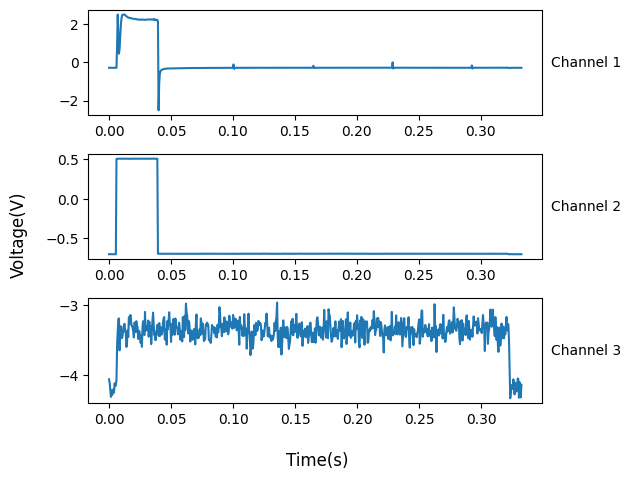

There are 665 points per channel. Please select an interval to set up base line.


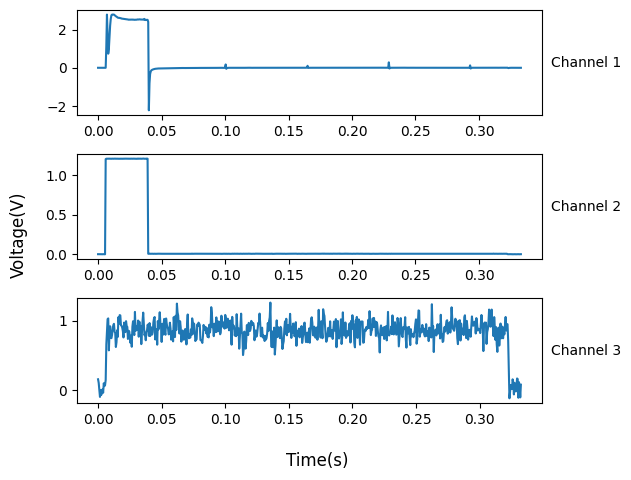

In [ ]:
def graph_user (file):
    chn,times=(channels_points(file))
    plt.show()
    offset_data(chn)
    raw_graph(chn,times)
    return 

graph_user(file)